This notebook explores the nodule dataframe created by the script `preprocessing/create_nodule_df.py`

In [2]:
from utils.common_imports import *

df = pd.read_csv(f"out/nodule_df.csv")
display(df.shape)
df.head(3)

(2625, 30)

,index,pid,nodule_idx,ann_mean_diameter,ann_mean_volume,nodule_annotation_ids,nodule_annotation_count,malignancy_scores,subtlety_scores,margin_scores,...,bbox_within_scan_128,malignancy_consensus,subtlety_consensus,margin_consensus,cancer_label,fold_1,fold_2,fold_3,fold_4,fold_5
0,0_LIDC-IDRI-0001,LIDC-IDRI-0001,0,32.755812,6989.673615,"(84, 85, 86, 87)",4,"(5, 5, 5, 4)","(5, 5, 5, 5)","(3, 4, 2, 4)",...,False,5,5,3,Malignant,test,train,train,train,train
1,0_LIDC-IDRI-0002,LIDC-IDRI-0002,0,30.781671,7244.667508,"(88, 89)",2,"(5, 4)","(2, 1)","(1, 2)",...,True,5,2,2,Malignant,train,train,test,train,train
2,0_LIDC-IDRI-0003,LIDC-IDRI-0003,0,31.664468,4731.410934,"(102,)",1,"(2,)","(1,)","(2,)",...,True,2,1,2,Benign,train,test,train,train,train


# EDA on Raw Attributes

## Malignancy distribution

In [2]:
print("Consensus cancer rate in nodules:")
df["cancer_label"].value_counts()

Consensus cancer rate in nodules:


cancer_label
Ambiguous    1244
Benign        890
Malignant     491
Name: count, dtype: int64

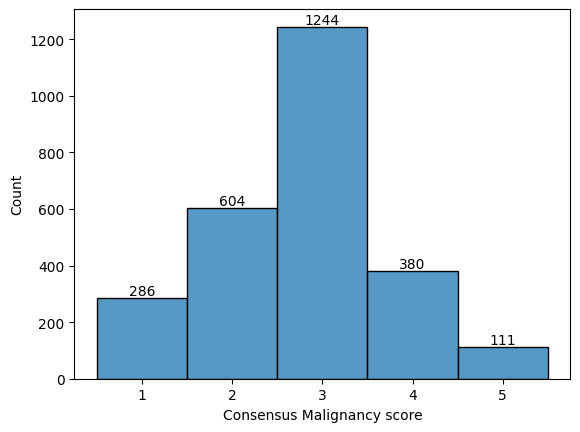

In [3]:
sns.histplot(data=df, x="malignancy_consensus", discrete=True)
vals = df["malignancy_consensus"].value_counts().sort_index().values
for i in range(0, 5):
    plt.text(i+1, vals[i], vals[i], ha="center", va="bottom")
plt.xlabel("Consensus Malignancy score")
plt.show()

## Nodule size - Diameter and Volume

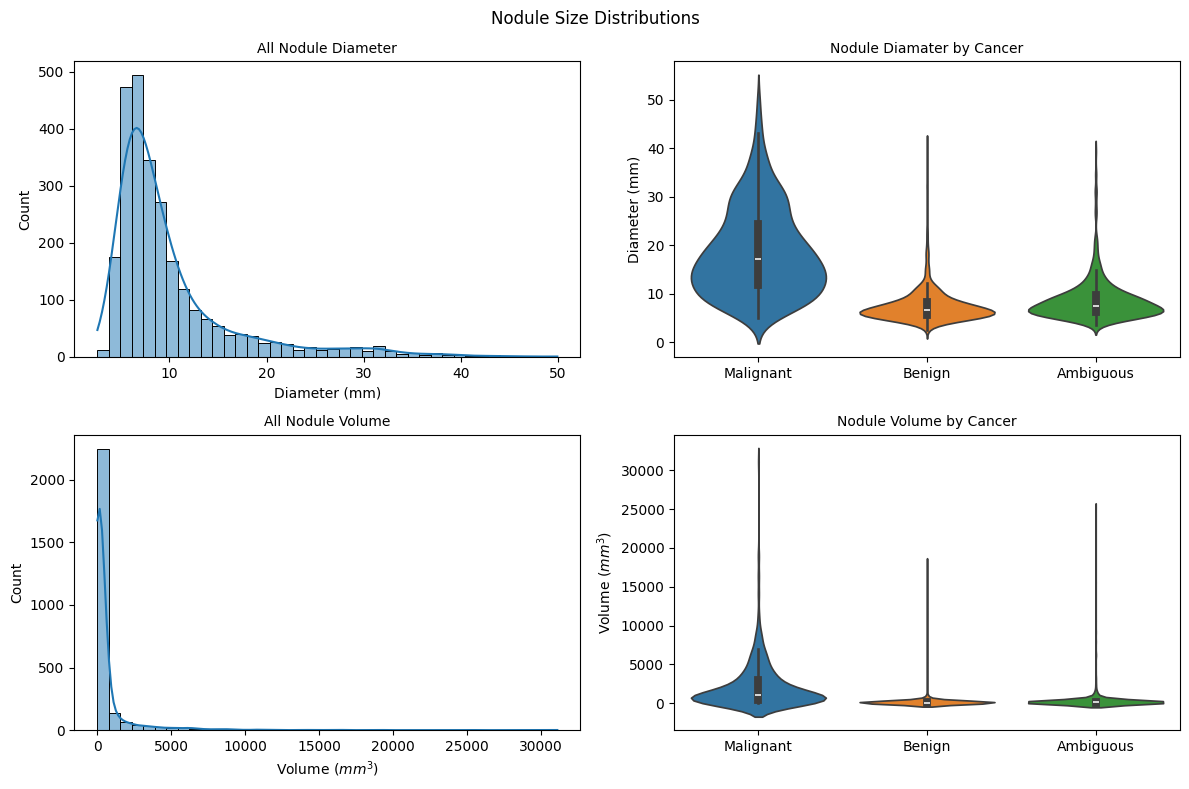

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

sns.histplot(data=df, x="ann_mean_diameter", bins=40, kde=True, ax=axs[0,0])
axs[0, 0].set_title("All Nodule Diameter", fontsize=10)
axs[0, 0].set_xlabel("Diameter (mm)")

sns.violinplot(data=df, x="cancer_label", y="ann_mean_diameter", hue="cancer_label", ax=axs[0,1])
axs[0, 1].set_title("Nodule Diamater by Cancer", fontsize=10)
axs[0, 1].set_xlabel("")
axs[0, 1].set_ylabel("Diameter (mm)")

sns.histplot(data=df, x="ann_mean_volume", bins=40, kde=True, ax=axs[1,0])
axs[1, 0].set_title("All Nodule Volume", fontsize=10)
axs[1, 0].set_xlabel("Volume ($mm^3$)")

sns.violinplot(data=df, x="cancer_label", y="ann_mean_volume", hue="cancer_label", ax=axs[1,1])
axs[1, 1].set_title("Nodule Volume by Cancer", fontsize=10)
axs[1, 1].set_xlabel("")
axs[1, 1].set_ylabel("Volume ($mm^3$)")

plt.suptitle("Nodule Size Distributions", fontsize=12)
plt.tight_layout()
plt.show()

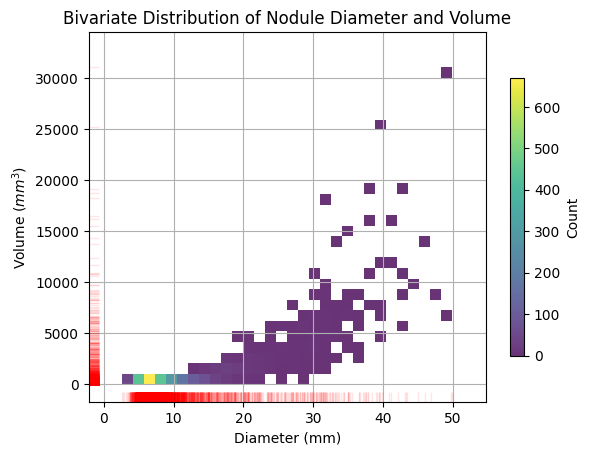

ann_mean_diameter
False    2622
True        3
Name: count, dtype: int64

In [5]:
sns.histplot(data=df, x="ann_mean_diameter", y="ann_mean_volume", bins=30, cbar=True, cbar_kws=dict(shrink=0.75, label="Count"), cmap="viridis", alpha=0.8)
sns.rugplot(data=df, x="ann_mean_diameter", y="ann_mean_volume", color="red", alpha=0.1)
plt.title("Bivariate Distribution of Nodule Diameter and Volume")
plt.ylabel("Volume $(mm^3)$")
plt.xlabel("Diameter (mm)")
plt.ylim(bottom=-1700)
plt.grid()
plt.show()

# also see the number of nodules with diameter <= 3mm
display((df["ann_mean_diameter"] <= 3).value_counts())

There are only 3 nodules smaller than 3 mm in diameter?

(0.999, 4.0]    2612
(4.0, 8.0]        13
Name: count, dtype: int64

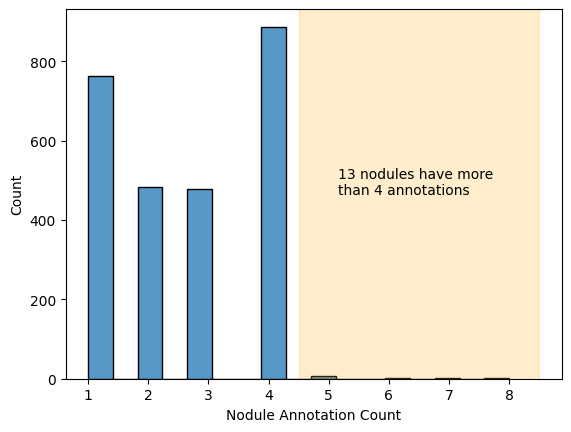

In [6]:
# Nodule Annotation Count
display(df["nodule_annotation_count"].value_counts(bins=[1,4, 8]))
sns.histplot(data=df, x="nodule_annotation_count")
plt.xlabel("Nodule Annotation Count")
plt.text(0.55, 0.5, f"{sum(df['nodule_annotation_count'] > 4)} nodules have more\nthan 4 annotations", transform=plt.gca().transAxes)
# color the right side of the plot
plt.axvspan(5-.5, 8+.5, color='orange', alpha=0.2)
plt.show()


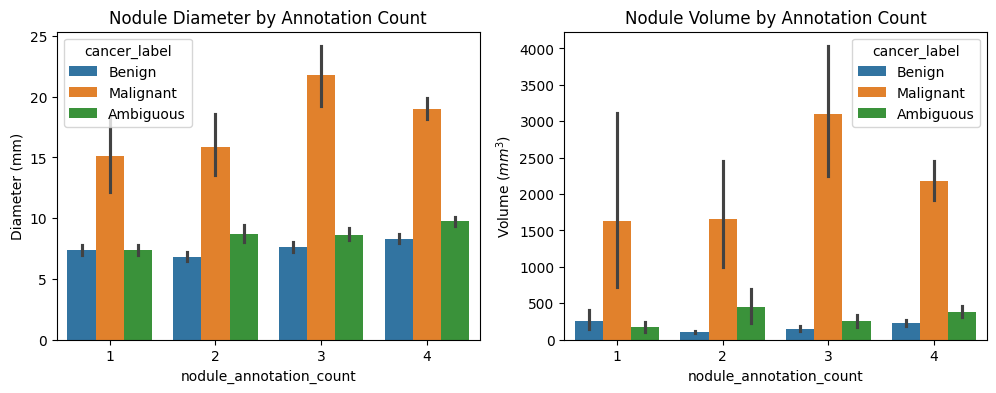

In [7]:
# stratify on nodule annotation count, and plot diameter
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
sns.barplot(data=df.query("nodule_annotation_count <= 4"), x="nodule_annotation_count", y="ann_mean_diameter", hue="cancer_label", ax=axs[0])
axs[0].set_title("Nodule Diameter by Annotation Count")
axs[0].set_ylabel("Diameter (mm)")
sns.barplot(data=df.query("nodule_annotation_count <= 4"), x="nodule_annotation_count", y="ann_mean_volume", hue="cancer_label", ax=axs[1])
axs[1].set_title("Nodule Volume by Annotation Count")
axs[1].set_ylabel("Volume $(mm^3)$")
plt.show()

In [8]:
# check if the nodules with multiple annotations belongs to the patient with mutliple scans:
pids = df.query("nodule_annotation_count > 4")["pid"].tolist()

for p in pids:
    print(len(pl.query(pl.Scan).filter(pl.Scan.patient_id == p).all()))

1
1
1
1
1
1
1
1
1
1
1
1
1


# Nodule per patient

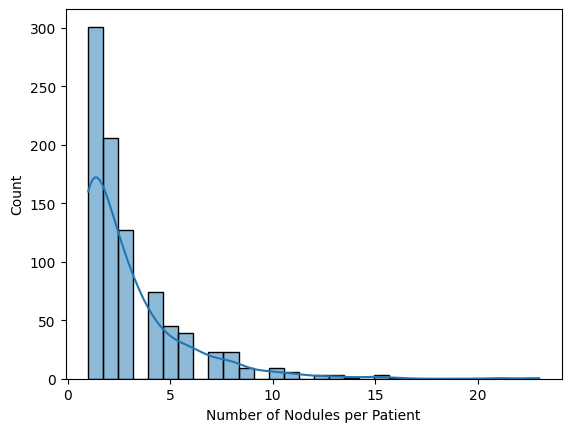

In [9]:
# This is useful for when we need to make the datasplits and for cross validation
sns.histplot(df.groupby("pid").size(), bins=30, kde=True)
plt.xlabel("Number of Nodules per Patient")
plt.show()

# Nodules with 1 annotation

In [10]:
one_ann_nod_df = df.query("nodule_annotation_count == 1")
one_ann_nod_df.head()

,index,pid,nodule_idx,ann_mean_diameter,ann_mean_volume,nodule_annotation_ids,nodule_annotation_count,malignancy_scores,subtlety_scores,margin_scores,...,bbox_within_scan_128,malignancy_consensus,subtlety_consensus,margin_consensus,cancer_label,fold_1,fold_2,fold_3,fold_4,fold_5
2,0_LIDC-IDRI-0003,LIDC-IDRI-0003,0,31.664468,4731.410934,"(102,)",1,"(2,)","(1,)","(2,)",...,True,2,1,2,Benign,train,test,train,train,train
9,2_LIDC-IDRI-0005,LIDC-IDRI-0005,2,6.264748,90.951783,"(109,)",1,"(2,)","(3,)","(5,)",...,False,2,3,5,Benign,train,test,train,train,train
10,0_LIDC-IDRI-0006,LIDC-IDRI-0006,0,6.987712,115.722656,"(116,)",1,"(2,)","(3,)","(5,)",...,True,2,3,5,Benign,train,test,train,train,train
12,2_LIDC-IDRI-0006,LIDC-IDRI-0006,2,15.051993,465.820312,"(123,)",1,"(2,)","(1,)","(2,)",...,False,2,1,2,Benign,train,test,train,train,train
15,1_LIDC-IDRI-0007,LIDC-IDRI-0007,1,20.684691,2228.546143,"(125,)",1,"(5,)","(4,)","(2,)",...,False,5,4,2,Malignant,train,train,train,test,train


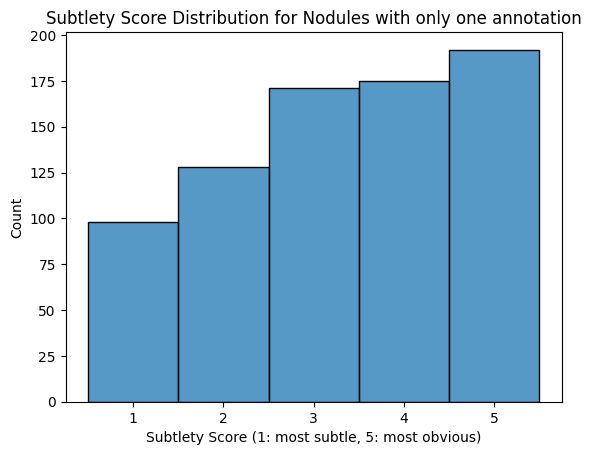

In [11]:
# get subtlety score for nodules with only one annotation
# Intuitively, for the nodules with only one annotation, the subtlety distribution should be skewed towards 1 (most of the nodules should be subtle)
# however, this is not the case as we see below....
sns.histplot(data=one_ann_nod_df, x="subtlety_consensus", discrete=True)
plt.xlabel("Subtlety Score (1: most subtle, 5: most obvious)")
plt.title("Subtlety Score Distribution for Nodules with only one annotation")
plt.show()

# See how many nodules exists with the specified bbox's

In [2]:
from utils.common_imports import *
nodule_df = pd.read_csv("out/nodule_df.csv")
nodule_df.columns

Index(['index', 'pid', 'nodule_idx', 'ann_mean_diameter', 'ann_mean_volume',
       'nodule_annotation_ids', 'nodule_annotation_count', 'malignancy_scores',
       'subtlety_scores', 'margin_scores', 'consensus_centroid',
       'consensus_bbox_10', 'bbox_within_scan_10', 'consensus_bbox_20',
       'bbox_within_scan_20', 'consensus_bbox_30', 'bbox_within_scan_30',
       'consensus_bbox_40', 'bbox_within_scan_40', 'consensus_bbox_50',
       'bbox_within_scan_50', 'consensus_bbox_60', 'bbox_within_scan_60',
       'consensus_bbox_70', 'bbox_within_scan_70', 'consensus_bbox_80',
       'bbox_within_scan_80', 'consensus_bbox_90', 'bbox_within_scan_90',
       'consensus_bbox_100', 'bbox_within_scan_100', 'malignancy_consensus',
       'subtlety_consensus', 'margin_consensus', 'cancer_label', 'fold_1',
       'fold_2', 'fold_3', 'fold_4', 'fold_5'],
      dtype='object')

,bbox_within_scan_10,bbox_within_scan_20,bbox_within_scan_30,bbox_within_scan_40,bbox_within_scan_50,bbox_within_scan_60,bbox_within_scan_70,bbox_within_scan_80,bbox_within_scan_90,bbox_within_scan_100
False,NaN,4,17,60,127,191,271,366,480,590
True,2625.0,2621,2608,2565,2498,2434,2354,2259,2145,2035


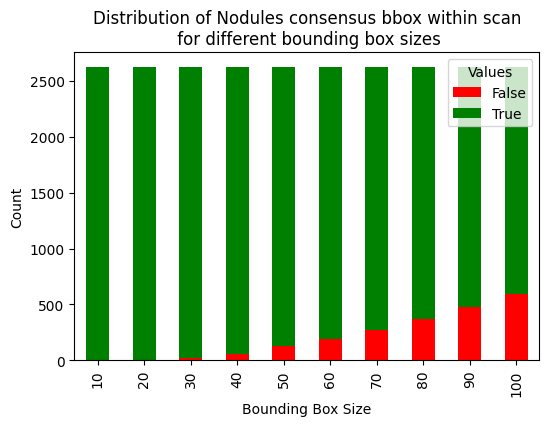

In [8]:
cols = [c for c in nodule_df.columns if c.startswith("bbox_within_scan")]
plot_df = nodule_df[cols]
counts = plot_df.apply(lambda x: x.value_counts())
display(counts)
counts.T.plot(kind="bar", stacked=True, color=["red", "green"], figsize=(6, 4))
plt.title("Distribution of Nodules consensus bbox within scan\n for different bounding box sizes")
plt.ylabel("Count")
plt.xticks(ticks=range(len(cols)), labels=[int(x.split("_")[-1]) for x in cols])
plt.xlabel("Bounding Box Size")
plt.legend(["False", "True"], title="Values")
plt.show()

# Filtering

In [14]:
fil_df = df.query("cancer_label != 'Ambiguous'")
fil_df["cancer_label"] = fil_df["cancer_label"].map({"Benign": 0, "Malignant": 1})
fil_df

# display(fil_df["cancer_label"].value_counts(normalize=True))

/var/folders/_c/vr22_fg12d7flyy_ll_m264w0000gp/T/ipykernel_56993/165000911.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fil_df["cancer_label"] = fil_df["cancer_label"].map({"Benign": 0, "Malignant": 1})


,index,pid,nodule_idx,ann_mean_diameter,ann_mean_volume,nodule_annotation_ids,nodule_annotation_count,malignancy_scores,subtlety_scores,margin_scores,...,bbox_within_scan_128,malignancy_consensus,subtlety_consensus,margin_consensus,cancer_label,fold_1,fold_2,fold_3,fold_4,fold_5
0,0_LIDC-IDRI-0001,LIDC-IDRI-0001,0,32.755812,6989.673615,"(84, 85, 86, 87)",4,"(5, 5, 5, 4)","(5, 5, 5, 5)","(3, 4, 2, 4)",...,False,5,5,3,1,test,train,train,train,train
1,0_LIDC-IDRI-0002,LIDC-IDRI-0002,0,30.781671,7244.667508,"(88, 89)",2,"(5, 4)","(2, 1)","(1, 2)",...,True,5,2,2,1,train,train,test,train,train
2,0_LIDC-IDRI-0003,LIDC-IDRI-0003,0,31.664468,4731.410934,"(102,)",1,"(2,)","(1,)","(2,)",...,True,2,1,2,0,train,test,train,train,train
3,1_LIDC-IDRI-0003,LIDC-IDRI-0003,1,31.001964,6519.463698,"(90, 93, 98, 99)",4,"(5, 5, 3, 4)","(5, 5, 5, 5)","(3, 3, 3, 4)",...,True,4,5,3,1,train,test,train,train,train
5,3_LIDC-IDRI-0003,LIDC-IDRI-0003,3,14.983128,1313.229390,"(92, 94, 96, 101)",4,"(4, 5, 3, 2)","(4, 5, 4, 3)","(5, 5, 5, 5)",...,False,4,4,5,1,train,test,train,train,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2620,0_LIDC-IDRI-1011,LIDC-IDRI-1011,0,28.675805,6039.291382,"(4484, 4486, 4489, 4492)",4,"(4, 3, 4, 3)","(5, 5, 5, 5)","(4, 3, 4, 5)",...,True,4,5,4,1,train,train,train,test,train
2621,1_LIDC-IDRI-1011,LIDC-IDRI-1011,1,32.859210,4170.822144,"(4483, 4487, 4490, 4493)",4,"(3, 5, 5, 5)","(5, 5, 5, 5)","(5, 2, 4, 4)",...,False,5,5,4,1,train,train,train,test,train
2622,2_LIDC-IDRI-1011,LIDC-IDRI-1011,2,22.721655,2185.342789,"(4482, 4485, 4488, 4494)",4,"(2, 5, 5, 5)","(3, 5, 5, 5)","(3, 2, 3, 4)",...,False,4,5,3,1,train,train,train,test,train
2623,3_LIDC-IDRI-1011,LIDC-IDRI-1011,3,6.544805,92.315674,"(4491,)",1,"(2,)","(1,)","(2,)",...,False,2,1,2,0,train,train,train,test,train
